In [3]:
# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

In [4]:
from EDA import *
from data_preprocessing import *
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from unet_model import *
from loss import *
import torch.optim as optim
from torchsummary import summary


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
#project_dir = os.path.dirname(os.path.abspath(__file__))
project_dir = os.getcwd() 
data_path = os.path.join(project_dir, "data")
print(data_path)

# EDA - image sizes, top text descriptions, sample data
#run_eda(data_path)

# Split data into train, val and test
#split_data(data_path)



c:\Users\User\Desktop\Spring_2025\CS597-ML Project\MMI_Unet_Lesion_Segmentation\data


In [9]:
# Preprocess the data - Resize and Augmentation
train_transforms = A.Compose([
    
    A.RandomScale(scale_limit=0.1, p=0.1),  # 10% zoom
    A.Resize(224, 224),
    ToTensorV2() #convert to tensor and normalize
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()   
])

train_dataset = SegmentationDataset(data_path, "train", transform=train_transforms)
val_dataset = SegmentationDataset(data_path, "val", transform=val_test_transforms) 
test_dataset = SegmentationDataset(data_path, "test",transform=val_test_transforms) 

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")



Number of training samples: 2183
Number of validation samples: 273
Number of testing samples: 273


In [10]:
BATCH_SIZE = 10
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [11]:
for images, masks in train_loader:
    print(f"Image type: {type(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Image data type: {images.dtype}")  

    print(f"Mask type: {type(masks)}")
    print(f"Mask shape: {masks.shape}")
    print(f"Mask data type: {masks.dtype}")
    break

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([10, 3, 224, 224])
Image data type: torch.float32
Mask type: <class 'torch.Tensor'>
Mask shape: torch.Size([10, 1, 224, 224])
Mask data type: torch.int64


In [2]:
from torchinfo import summary
from mmi_unet_model import MMI_UNet
import torch

model = MMI_UNet(out_channels=1)

summary(model)

Layer (type:depth-idx)                                                 Param #
MMI_UNet                                                               --
├─ConvNeXtEncoder: 1-1                                                 --
│    └─ConvNextModel: 2-1                                              --
│    │    └─ConvNextEmbeddings: 3-1                                    4,896
│    │    └─ConvNextEncoder: 3-2                                       27,813,696
│    │    └─LayerNorm: 3-3                                             1,536
│    └─ConvNextStage: 2-2                                              (recursive)
│    │    └─Identity: 3-4                                              --
│    │    └─Sequential: 3-5                                            (recursive)
│    └─ConvNextStage: 2-3                                              (recursive)
│    │    └─Sequential: 3-6                                            (recursive)
│    │    └─Sequential: 3-7                              

In [3]:
images = torch.randn(1, 3, 224, 224)  
reports = [
"Bilateral pulmonary infection, two infected areas, all left lung and middle right lung."
]

# The model handles the text encoding internally
segmentation_maps = model(images, reports)

In [4]:
print(segmentation_maps)

tensor([[[[0.5006, 0.3818, 0.4546,  ..., 0.4380, 0.4953, 0.4611],
          [0.4515, 0.5184, 0.4389,  ..., 0.4348, 0.3193, 0.5655],
          [0.4517, 0.3994, 0.4455,  ..., 0.4465, 0.3380, 0.4390],
          ...,
          [0.5033, 0.5410, 0.4446,  ..., 0.5012, 0.3564, 0.5633],
          [0.4994, 0.5314, 0.4528,  ..., 0.4628, 0.4826, 0.3583],
          [0.4854, 0.4392, 0.4169,  ..., 0.5012, 0.5204, 0.5142]]]],
       grad_fn=<SigmoidBackward0>)


In [19]:
from loss import *
from train import *
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MMI_UNet(in_channels=1, out_channels=1).to(device)

# Loss and optimizer
criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, epochs=3)


Epoch [1/3], Batch [1/219] - Loss: 1.6363
Epoch [1/3], Batch [2/219] - Loss: 1.6294
Epoch [1/3], Batch [3/219] - Loss: 1.5943
Epoch [1/3], Batch [4/219] - Loss: 1.5842
Epoch [1/3], Batch [5/219] - Loss: 1.5440
Epoch [1/3], Batch [6/219] - Loss: 1.5741
Epoch [1/3], Batch [7/219] - Loss: 1.5465
Epoch [1/3], Batch [8/219] - Loss: 1.5486
Epoch [1/3], Batch [9/219] - Loss: 1.5108
Epoch [1/3], Batch [10/219] - Loss: 1.5336
Epoch [1/3], Batch [11/219] - Loss: 1.5185
Epoch [1/3], Batch [12/219] - Loss: 1.4673
Epoch [1/3], Batch [13/219] - Loss: 1.4937
Epoch [1/3], Batch [14/219] - Loss: 1.4908
Epoch [1/3], Batch [15/219] - Loss: 1.4933
Epoch [1/3], Batch [16/219] - Loss: 1.4295
Epoch [1/3], Batch [17/219] - Loss: 1.4417
Epoch [1/3], Batch [18/219] - Loss: 1.4670
Epoch [1/3], Batch [19/219] - Loss: 1.4553
Epoch [1/3], Batch [20/219] - Loss: 1.4196
Epoch [1/3], Batch [21/219] - Loss: 1.4520
Epoch [1/3], Batch [22/219] - Loss: 1.4573
Epoch [1/3], Batch [23/219] - Loss: 1.4194
Epoch [1/3], Batch [

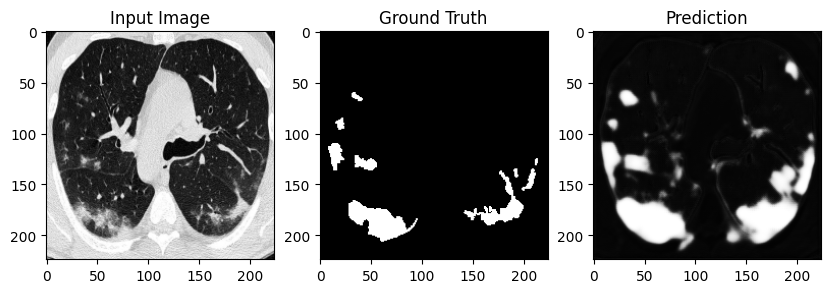

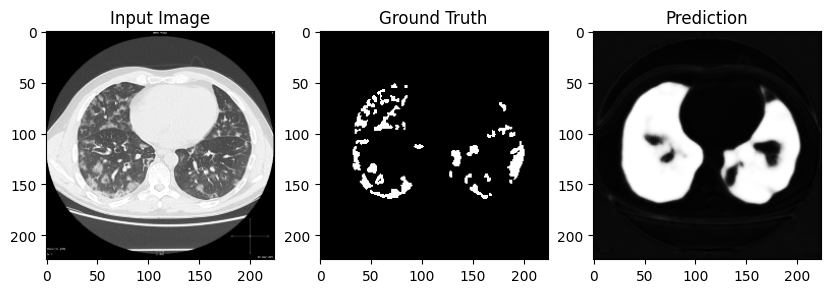

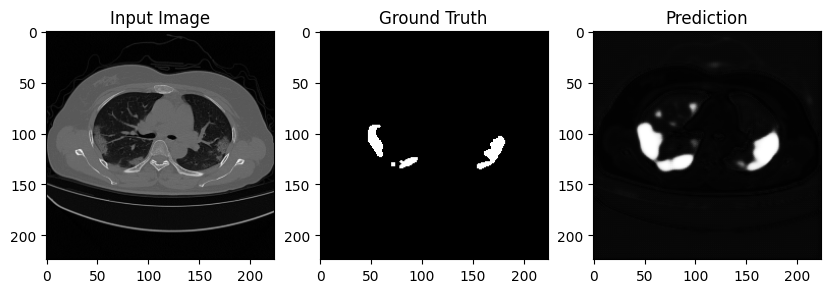

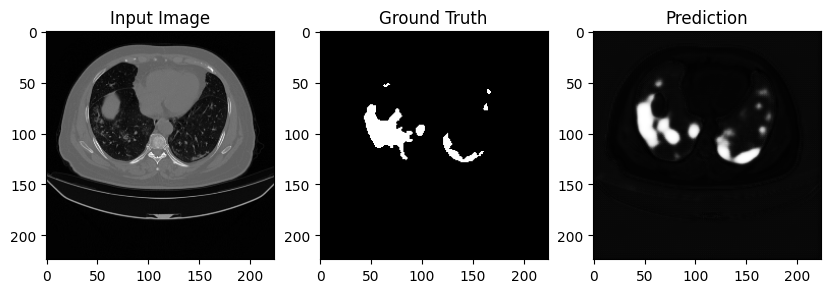

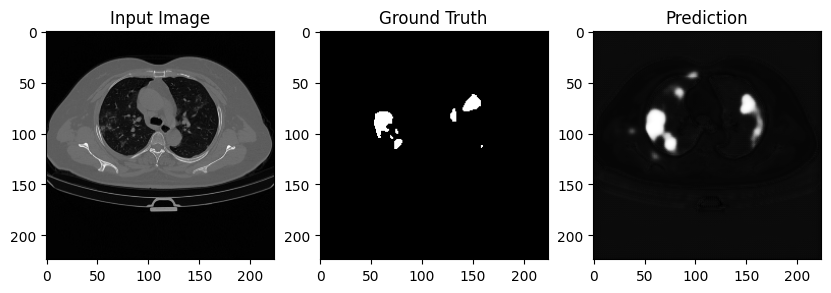

Test Dice Score: 0.4612
Test IoU Score: 0.3162


In [ ]:
#model = UNet(in_channels=1, out_channels=1).to(device)
#model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

total_dice, total_iou, num_samples = 0, 0, 0


with torch.no_grad():
    for i, (image, mask) in enumerate(test_loader):
        image, mask = image.to(device), mask.to(device)
        pred = model(image)
        pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities

        # Compute Dice and IoU
        dice = dice_score(pred, mask).item()
        iou = iou_score(pred, mask).item()
        total_dice += dice
        total_iou += iou
        num_samples += 1

        # Visualize results for first few samples
        if i < 5:  
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image.cpu()[0].squeeze(0), cmap="gray")
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(mask.cpu()[0].squeeze(0), cmap="gray")
            plt.title("Ground Truth")
            plt.subplot(1, 3, 3)
            plt.imshow(pred.cpu()[0].squeeze(0), cmap="gray")
            plt.title("Prediction")
            plt.show()

# Print final test metrics
print(f"Test Dice Score: {total_dice / num_samples:.4f}")
print(f"Test IoU Score: {total_iou / num_samples:.4f}")